In [68]:
import navis
import numpy as np 
import networkx as nx 

from os import listdir
from os.path import isfile, join
from pathlib import Path 
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from standard_transform import minnie_transform_nm
axons =  '/Users/jan/Documents/Microns/Microns/MicronsBaselineModel/skeletons/axons'
dendrites = '/Users/jan/Documents/Microns/Microns/MicronsBaselineModel/skeletons/dendrites'
axon_files = [join(axons, f) for f in listdir(axons) if isfile(join(axons, f))]
dendrites_files = [join(dendrites, f) for f in listdir(dendrites) if isfile(join(dendrites, f))]


In [ ]:
from utils import MinnieData

mdata = MinnieData()

In [55]:

sst_neurons = mdata.get_fully_extended(mdata.get_cells_stype('sst')['pt_root_id'])
l23_neurons = mdata.get_dorkenwald_neurons_l23()['pre']
print(len(sst_neurons))
print(len(l23_neurons))

Lost neurons in inital l23 neurons: False
[[ 666.61100865 -196.67104429  856.69494   ]] [[666.61121806 803.32882537 856.69494   ]]
41
202


In [90]:

threshold = 2.0
connectivity_entries = []
transf = minnie_transform_nm()
for ax_name in sst_neurons:
    synapses = mdata.client.materialize.query_table("synapses_pni_2", filter_in_dict={"pre_pt_root_id": [ax_name], "post_pt_root_id": l23_neurons})
    for dend_name in l23_neurons:
        ax = Path(f'/Users/jan/Documents/Microns/Microns/MicronsBaselineModel/skeletons/axons/{ax_name}.swc')
        dend = Path(f'/Users/jan/Documents/Microns/Microns/MicronsBaselineModel/skeletons/dendrites/{dend_name}.swc')
       
        if ax.name != dend.name:
            print(ax.name, dend.name)
            ax_sk = navis.read_swc(ax)
            ax_sk = navis.resample_skeleton(ax_sk, resample_to='0.5 microns')
            dend_sk = navis.read_swc(dend)
            dend_sk = navis.resample_skeleton(dend_sk, resample_to='0.5 microns')
            overlap_dict = []
            dend_pos = dend_sk.nodes[['x', 'y', 'z']].values
            for _,ax_node in ax_sk._get_nodes().iterrows():
                ax_node_pos = ax_node[['x', 'y', 'z']].values[np.newaxis, ...]
                ax_node_id = ax_node['node_id']
                
                distances = np.sqrt(np.sum((dend_pos-ax_node_pos)**2, axis=1).astype(float))
                distances_bin = distances <= threshold
                if distances_bin.sum() > 0.0:
                    overlap_dict.append({'ax_node_id': ax_node_id, "post_pt_root_id": dend.stem, "min_dist": distances.min()})
            
            ax_graph = ax_sk.graph 
            # we now try to fuse continous nodes into overlap sections
            groups = [l['ax_node_id'] for l in overlap_dict]
            
            finished_groups = []
            subgraph = ax_graph.subgraph(groups)
            finished_groups = [list(c) for c in nx.connected_components(subgraph.to_undirected())]
            axdend_synapses = synapses[synapses['post_pt_root_id'] == dend_name]
            
            skeleton_nodes = ax_sk.vertices  # shape: (N, 3)
            tree = cKDTree(skeleton_nodes)
            resolution = [4,4,40]
            pre_indices = np.array([])
            if len(axdend_synapses):
                incoming_synapses = transf.apply(np.array(axdend_synapses['pre_pt_position'].values.tolist()) * resolution)
                distances, pre_indices = tree.query(incoming_synapses)
                pre_indices = ax_sk.nodes['node_id'].values[pre_indices]
            
            new_entry = {"pre_pt_root_id" : ax_name, "post_pt_root_id": dend_name, "num_synapses": len(axdend_synapses), 'syn_nodes' : pre_indices.tolist(), "syn_sizes": axdend_synapses['size'].values.tolist()}
            for i,group in enumerate(finished_groups):
                new_entry[f"group_{i}"] = group
            print(new_entry)
            connectivity_entries.append(new_entry)
            highlight_nodes = set().union(*finished_groups)
            ax_sk.nodes['radius'] = 0.2  # baseline radius
            dend_sk.nodes['radius'] = 0.2
            ax_sk.nodes.loc[ax_sk.nodes['node_id'].isin(highlight_nodes), 'radius'] = 1
            ax_sk.nodes.loc[ax_sk.nodes['node_id'].isin(pre_indices), 'radius'] = 5
            
            #navis.plot3d([ax_sk, dend_sk], radius=True, colors=['white', 'yellow'])
            #plt.show()
            
            #break
        #break
    
    #break
            

            

864691136578765076.swc 864691135257638831.swc
{'pre_pt_root_id': 864691136578765076, 'post_pt_root_id': 864691135257638831, 'num_synapses': 6, 'syn_nodes': [88806, 78712, 81408, 78345, 82687, 76952], 'syn_sizes': [3812, 4276, 6676, 1540, 5516, 4928], 'group_0': [81408, 81409, 81410, 81411, 81412, 81413, 81404, 81405, 81406, 81407], 'group_1': [78341, 78342, 78343, 78344, 78345, 78346, 78347, 78348], 'group_2': [82688, 82689, 82690, 82691, 82692, 82693, 82694], 'group_3': [49026, 88804, 88805, 88806, 88807, 88808, 84873, 84874, 80027, 80028], 'group_4': [89483, 89484, 89485, 89486, 89487, 89488], 'group_5': [76960, 76961, 76950, 76951, 76952, 76953, 76954, 76955, 76956, 76957, 76958, 76959], 'group_6': [80555, 80556, 80557, 80558, 80559, 80560], 'group_7': [85600, 85595, 85596, 85597, 85598, 85599], 'group_8': [78713, 78714, 78715, 78716]}
864691136578765076.swc 864691135346598047.swc
{'pre_pt_root_id': 864691136578765076, 'post_pt_root_id': 864691135346598047, 'num_synapses': 0, 'syn_n

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

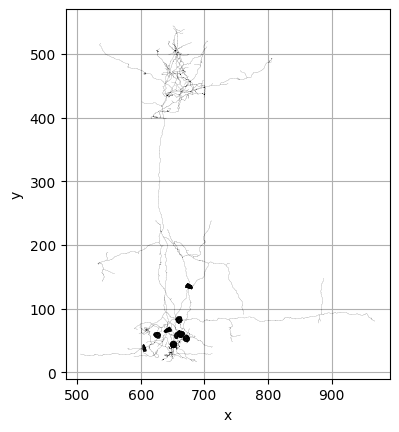

In [87]:
ax_sk.nodes['radius'] = 0.05  # baseline radius
dend_sk.nodes['radius'] = 0.2
ax_sk.nodes.loc[ax_sk.nodes['node_id'].isin(highlight_nodes), 'radius'] = 6
#ax_sk.nodes.loc[ax_sk.nodes['node_id'].isin(pre_indices), 'radius'] = 8
navis.plot2d([ax_sk], radius=True, colors='black')